In [1]:
import tensorflow as tf
import numpy as np
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, normalize
import sys
import glob
import pylab
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras_metrics import recall, precision

Using TensorFlow backend.


In [16]:
WINDOW_SIZE = 60
TRAIN_TEST_SPLIT = 0.8 # set to 0.1 for other stocks data testing

In [3]:
def preprocess(fname, cut=0):
    print("preparing data...")
    df = pd.read_csv(fname)[-cut:]
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    signals = np.array(df["close"] - df["close"].shift() > 0).astype(int)[1:]
    df = df[:-1]
    indicators = df.copy()
    print("calculating indicators...")
    indicators['true_signals'] = signals
    indicators['KAMA'] = TA.KAMA(df)
    indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    indicators['TEMA20'] = TA.TEMA(df, period=20)
    indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA40'] = TA.EMA(df, period=40)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    indicators['RSI7'] = TA.RSI(df, period=7)
    indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    indicators['ATR'] = TA.ATR(df)
    print("assigining indicators...")
    indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    signals = np.array(indicators.pop('true_signals'))
    
    print("splitting data...")
    prices = indicators.close.copy()[WINDOW_SIZE-1:-1]
    indicators = np.array([normalize(indicators[i:i+WINDOW_SIZE], axis=0, norm='max')
                  for i in range(len(indicators) - WINDOW_SIZE)])
    signals = signals[WINDOW_SIZE-1:-1]
    
    if len(indicators) != len(signals):
        raise RuntimeError("len(indicators) != len(signals)")
    if len(signals) != len(prices):
        raise RuntimeError("len(signals)(%s) != len(prices)(%s)" % (len(signals), len(prices)))
        
    split_index = int(TRAIN_TEST_SPLIT*len(prices))
    data_train, signals_train, prices_train = indicators[:split_index], signals[:split_index], prices[:split_index]
    data_test, signals_test, prices_test = indicators[split_index:], signals[split_index:], prices[split_index:]
    print("done!")
    
    return data_train, signals_train, prices_train, data_test, signals_test, prices_test

In [19]:
data_train, signals_train, prices_train, data_test, signals_test, prices_test = preprocess("./quotes/sbrf4.csv")

preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!


In [17]:
conv_size = data_train.shape[-1]
i = Input(shape=(WINDOW_SIZE, conv_size))
lstm = CuDNNLSTM(24, return_sequences=True)(i)
lstm = CuDNNLSTM(8, return_sequences=False)(lstm)
conv2 = Reshape((WINDOW_SIZE, conv_size, 1))(i)
conv2 = Conv2D(16, (1, conv_size), padding='valid')(conv2)
conv2 = ReLU()(conv2)
conv2 = Reshape((WINDOW_SIZE, 16))(conv2)
x = concatenate([i, conv2])
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(32, kernel_size=4)(x)
x = ReLU()(x)
x = MaxPool1D()(x)
x = Dropout(0.1)(x)
x = Conv1D(32, kernel_size=3)(x)
x = ReLU()(x)
x = MaxPool1D()(x)
x = Dropout(0.1)(x)
x = Conv1D(32, kernel_size=3)(x)
x = ReLU()(x)
x = MaxPool1D()(x)
x = BatchNormalization()(x)
lstm2 = CuDNNLSTM(8, return_sequences=True)(x)
lstm2 = CuDNNLSTM(8, return_sequences=False)(lstm2)
x = Dropout(0.1)(x)
x = Conv1D(32, kernel_size=3)(x)
x = ReLU()(x)
x = MaxPool1D()(x)
x = Flatten()(x)
x = Dense(8)(x)
x = ReLU()(x)
x = concatenate([x, lstm, lstm2])
x = BatchNormalization()(x)
x = Dense(8)(x)
x = ReLU()(x)
x = Dense(8)(x)
x = ReLU()(x)
x = BatchNormalization()(x)
o = Dense(1, activation='sigmoid')(x)


model = tf.keras.models.Model(inputs=i, outputs=o)
model.compile(optimizer=Adam(0.001, epsilon=1e-7), loss='binary_crossentropy', metrics=['accuracy'])

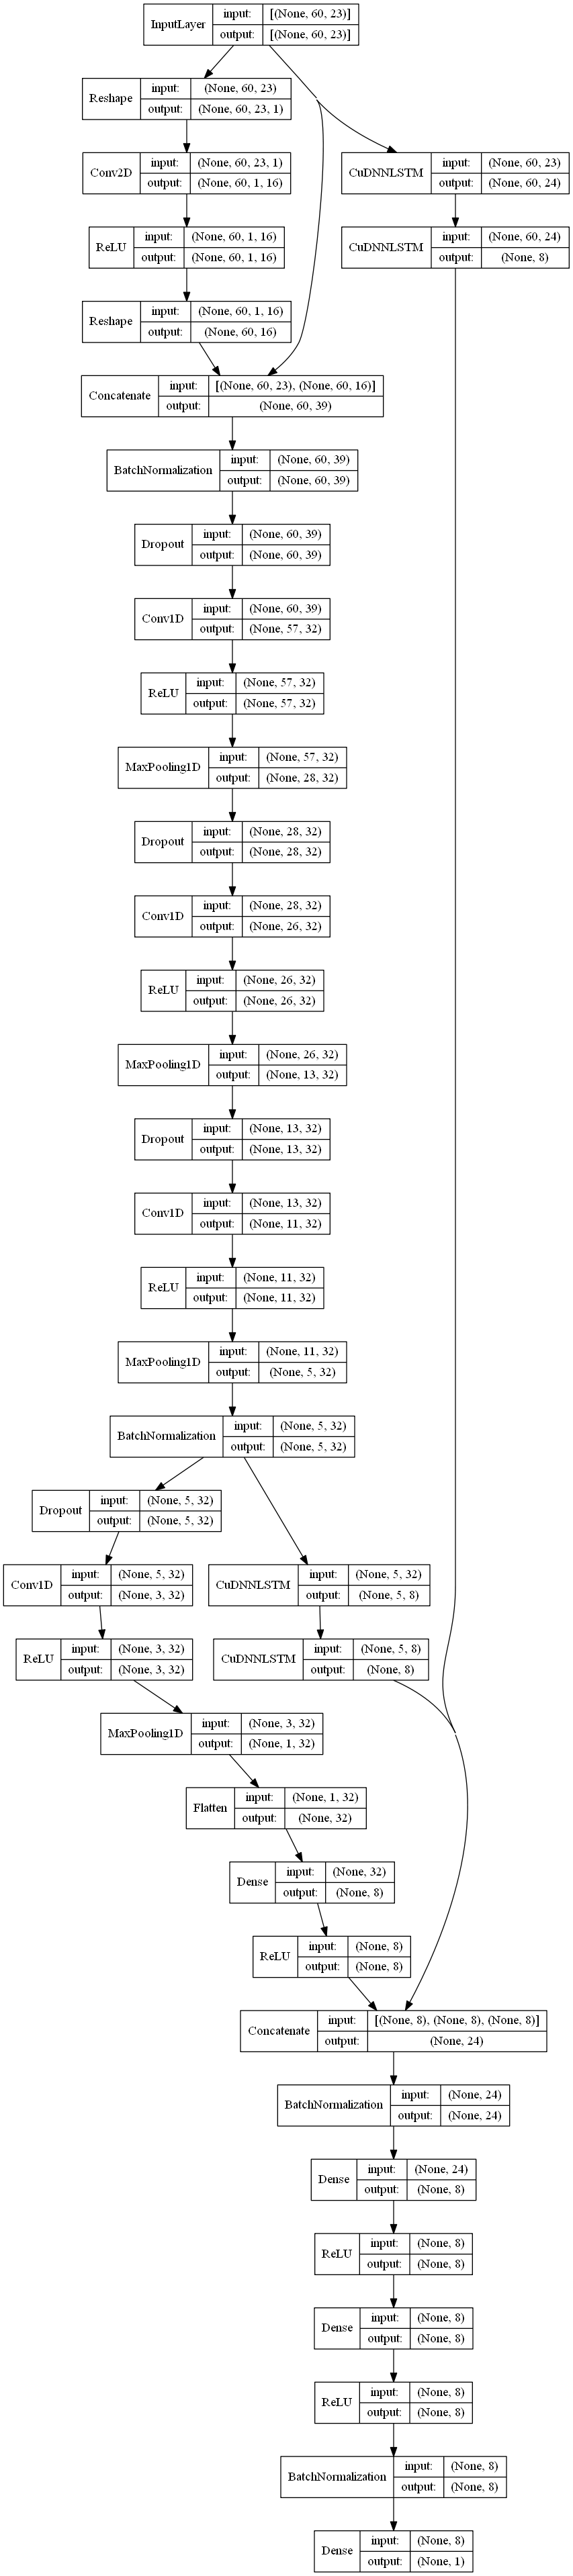

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='TB')

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 23)]     0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 60, 23, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 1, 16)    384         reshape_2[0][0]                  
__________________________________________________________________________________________________
re_lu_8 (ReLU)                  (None, 60, 1, 16)    0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [20]:
model.fit(data_train, signals_train, epochs=800, validation_data=(data_test, signals_test), shuffle=False)

Train on 210088 samples, validate on 52522 samples
Epoch 1/800
210088/210088 [==============================] - 316s 2ms/sample - loss: 0.6793 - acc: 0.5673 - val_loss: 0.7491 - val_acc: 0.5132
Epoch 2/800
210088/210088 [==============================] - 247s 1ms/sample - loss: 0.6572 - acc: 0.6016 - val_loss: 0.8059 - val_acc: 0.5156
Epoch 3/800
210088/210088 [==============================] - 243s 1ms/sample - loss: 0.6472 - acc: 0.6132 - val_loss: 0.8841 - val_acc: 0.5153
Epoch 4/800
210088/210088 [==============================] - 233s 1ms/sample - loss: 0.6397 - acc: 0.6247 - val_loss: 0.8443 - val_acc: 0.5122
Epoch 5/800
210088/210088 [==============================] - 221s 1ms/sample - loss: 0.6322 - acc: 0.6320 - val_loss: 0.8022 - val_acc: 0.5120
Epoch 6/800
210088/210088 [==============================] - 221s 1ms/sample - loss: 0.6237 - acc: 0.6422 - val_loss: 0.8423 - val_acc: 0.5053
Epoch 7/800
210088/210088 [==============================] - 222s 1ms/sample - loss: 0.6153

KeyboardInterrupt: 

In [21]:
tf.keras.models.save_model(model, 'monster_ref.h5')

In [282]:
model.evaluate(data_test, signals_test)

1314/1314 [==============================] - 0s 358us/sample - loss: 0.6932 - acc: 0.5046


[0.6931573074520814, 0.5045662]

In [286]:
preds = model.predict(data_test)

In [306]:
tf.keras.models.save_model(model, 'monster.h5')

# Тесты 1Н

In [9]:
minutes_dirs = glob.glob("./quotes/*4.csv")
hours_dirs = glob.glob("./quotes/*7.csv")
days_dirs = glob.glob("./quotes/*8.csv")

In [10]:
COMISSION = 0.05/100
BROKER_COMISSION = 10

def model_test(fname, data_test, dfcopy):
    sure = SURE
    money = 100000
    cur_stocks = 0

    sells = []
    buys = []
    stats = []

    preds = model.predict(data_test)
    temp_df = np.array(dfcopy.copy())
    #temp_df = temp_df[int(len(dfcopy)*TRAIN_TEST_SPLIT):].values
    for i, p in enumerate(preds):
        price = temp_df[i]
        if abs(p - 0.5) > sure:
            if p <= 0.5:
                if cur_stocks > 0:
                    sells.append(i)
                    money -= BROKER_COMISSION
                #n_stocks = money // price
                money += cur_stocks*price*(1-COMISSION)
                cur_stocks = 0
            else:
                n_stocks = money // price
                if n_stocks > 0:
                    buys.append(i)
                    money -= BROKER_COMISSION
                money -= n_stocks*price*(1+COMISSION)
                cur_stocks += n_stocks
        stats.append(price*cur_stocks + money)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(fname, fontsize=20)
    axes[0].set_title("Зависимость стоимости акций (цена закрытия) от времени")
    axes[0].plot(temp_df)
    axes[0].plot(temp_df, '^', markersize=10, color='m', label = 'buying signal', markevery = buys, alpha=0.5)
    axes[0].plot(temp_df, 'v', markersize=10, color='k', label = 'selling signal', markevery = sells, alpha=0.5)
    #axes[0].plot(temp_df, '.', markersize=1, color='m', label = 'buying signal', markevery = buys, alpha=1)
    #axes[0].plot(temp_df, '.', markersize=1, color='k', label = 'selling signal', markevery = sells, alpha=1)
    axes[0].legend()
    axes[0].set_xlabel("Время")
    axes[0].set_ylabel("Цена закрытия")
    axes[0].grid()
    
    axes[1].set_title("Зависимость количества средств от времени")
    axes[1].plot(stats)
    axes[1].set_xlabel("Время")
    axes[1].set_ylabel("Всего средств")
    axes[1].grid()

    fig.tight_layout(pad=3)
    
def automated_test(fname, title, cut=0):
    data_train, signals_train, prices_train, data_test, signals_test, prices_test = preprocess(fname, cut=cut)
    model_test(title, data_test, prices_test)

preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!


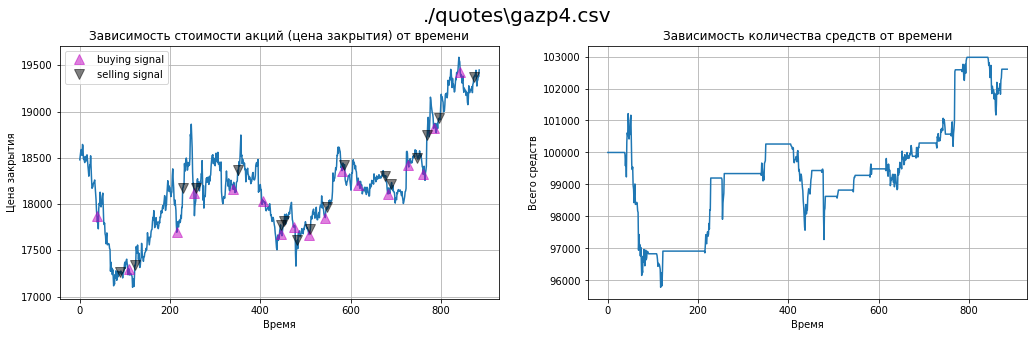

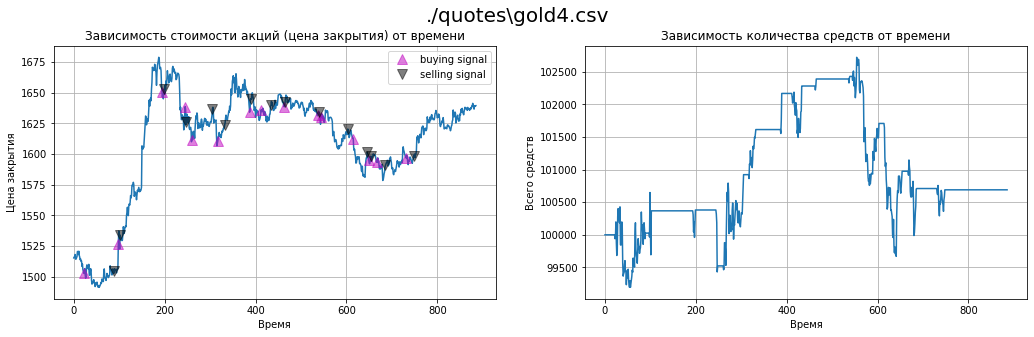

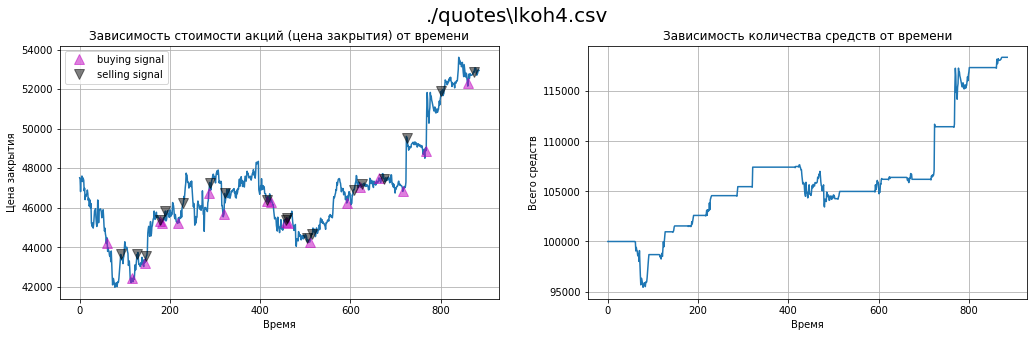

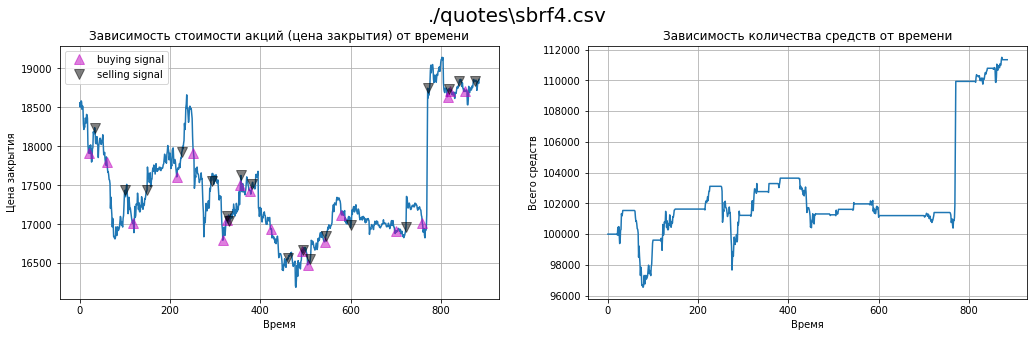

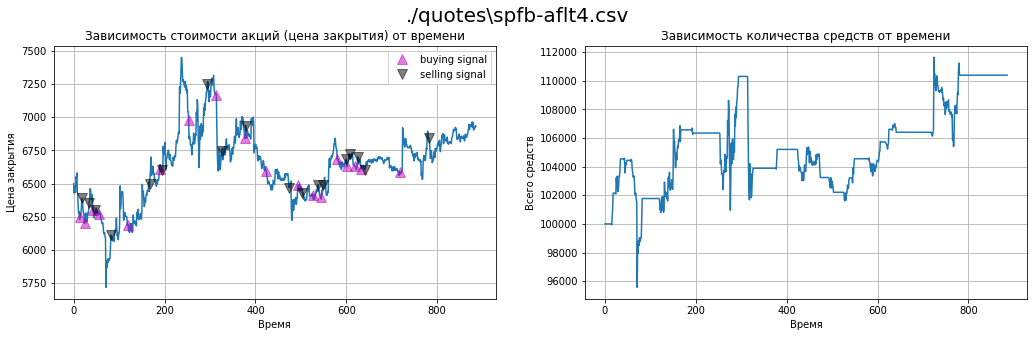

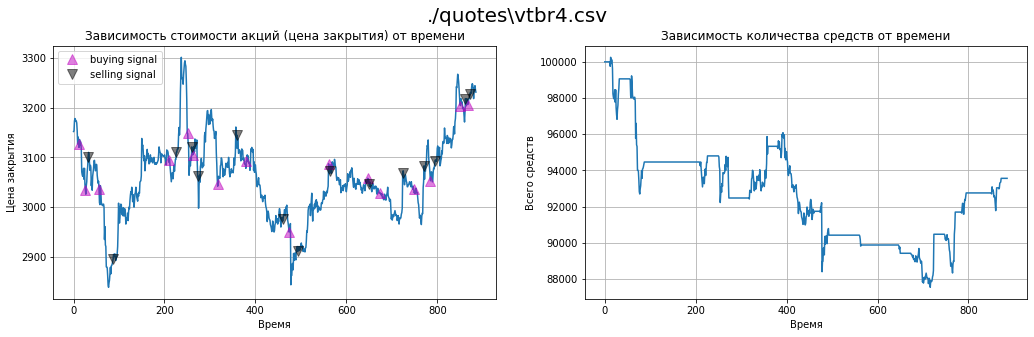

In [22]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in minutes_dirs:
    automated_test(p, p, cut=1000)